# Time series forecasting with ARIMA

In this notebook, we demonstrate how to:
- prepare time series data for training an ARIMA time series forecasting model
- implement a simple ARIMA model to forecast the next HORIZON steps ahead (time *t+1* through *t+HORIZON*) in the time series
- evaluate the model 


The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [8]:
energy = load_data('./data')[['load']]
energy.head(10)

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"
2012-01-01 05:00:00,"2,453.00"
2012-01-01 06:00:00,"2,560.00"
2012-01-01 07:00:00,"2,719.00"
2012-01-01 08:00:00,"2,916.00"
2012-01-01 09:00:00,"3,105.00"


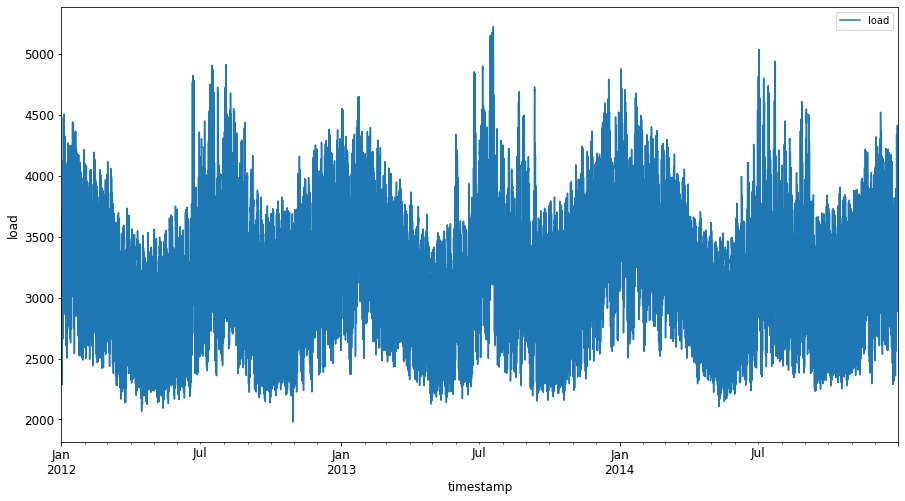

In [9]:
energy.plot(y="load", subplots=True, figsize=(15,8), fontsize=12)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

In [10]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

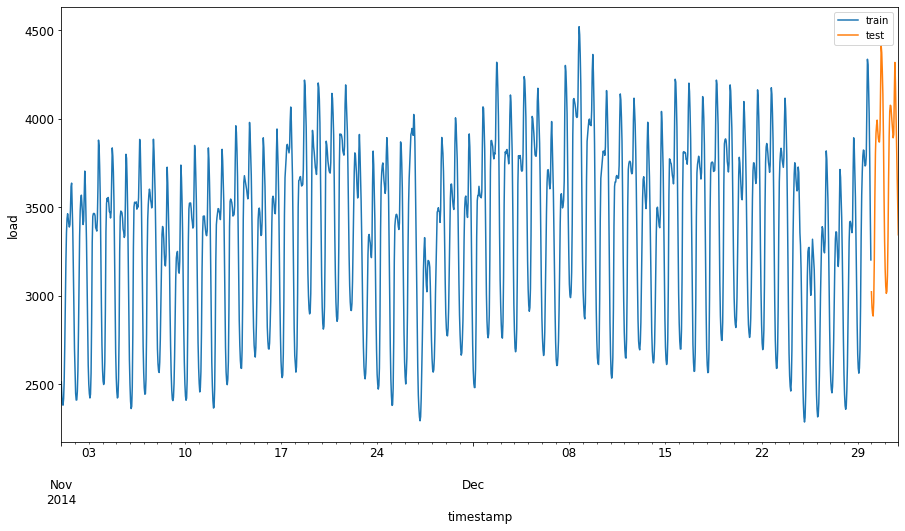

In [11]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [12]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [13]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
2014-11-01 00:00:00,0.10
2014-11-01 01:00:00,0.07
2014-11-01 02:00:00,0.05
2014-11-01 03:00:00,0.04
2014-11-01 04:00:00,0.06
2014-11-01 05:00:00,0.10
2014-11-01 06:00:00,0.19
2014-11-01 07:00:00,0.31
2014-11-01 08:00:00,0.40
2014-11-01 09:00:00,0.48


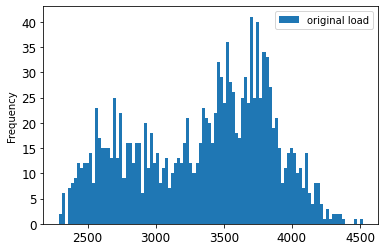

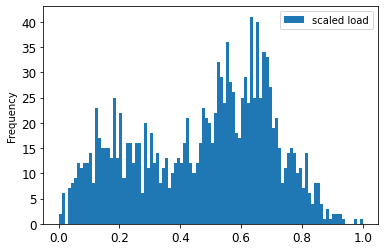

In [14]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [15]:
test['load'] = scaler.transform(test)
test.head()

,load
2014-12-30 00:00:00,0.33
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.27
2014-12-30 03:00:00,0.27
2014-12-30 04:00:00,0.30


In [16]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [17]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.45318D+00    |proj g|=  2.50788D+00


 This problem is unconstrained.



At iterate    5    f= -2.45390D+00    |proj g|=  4.50193D-01

At iterate   10    f= -2.45541D+00    |proj g|=  1.49646D+00

At iterate   15    f= -2.45565D+00    |proj g|=  9.53388D-02

At iterate   20    f= -2.45566D+00    |proj g|=  1.43473D-01

At iterate   25    f= -2.45568D+00    |proj g|=  3.66191D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     44      1     0     0   3.009D-02  -2.456D+00
  F =  -2.4556777709242450     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:        

In [18]:
test_shifted = test.copy()

for t in range(1, HORIZON+1):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2,load+3
2014-12-30 00:00:00,0.33,0.29,0.27,0.27
2014-12-30 01:00:00,0.29,0.27,0.27,0.30
2014-12-30 02:00:00,0.27,0.27,0.30,0.41
2014-12-30 03:00:00,0.27,0.30,0.41,0.57
2014-12-30 04:00:00,0.30,0.41,0.57,0.68


In [19]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41942D+00    |proj g|=  1.50341D+00


 This problem is unconstrained.



At iterate    5    f= -2.42003D+00    |proj g|=  1.29322D+00

At iterate   10    f= -2.42282D+00    |proj g|=  1.14039D-01

At iterate   15    f= -2.42284D+00    |proj g|=  8.92238D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     78      2     0     0   3.033D-02  -2.423D+00
  F =  -2.4228392805597729     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41939D+00    |proj g|=  1.51571D+00


 This problem is unconstrained.



At iterate    5    f= -2.42009D+00    |proj g|=  1.39631D+00

At iterate   10    f= -2.42275D+00    |proj g|=  3.84655D-02

At iterate   15    f= -2.42280D+00    |proj g|=  3.65111D-03

At iterate   20    f= -2.42280D+00    |proj g|=  5.17451D-02

At iterate   25    f= -2.42280D+00    |proj g|=  4.54735D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     76      1     0     0   4.547D-02  -2.423D+00
  F =  -2.4227998142781400     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42057D+00    |proj g|=  1.40865D+00


 This problem is unconstrained.



At iterate    5    f= -2.42093D+00    |proj g|=  1.07339D+00

At iterate   10    f= -2.42388D+00    |proj g|=  3.77951D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     26      1     0     0   2.337D-02  -2.424D+00
  F =  -2.4239143698860079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly

 This problem is unconstrained.



At iterate    5    f= -2.42207D+00    |proj g|=  4.13672D-01

At iterate   10    f= -2.42533D+00    |proj g|=  5.32524D-02

At iterate   15    f= -2.42548D+00    |proj g|=  6.46720D-01

At iterate   20    f= -2.42555D+00    |proj g|=  1.99544D-01

At iterate   25    f= -2.42555D+00    |proj g|=  1.45874D-02

At iterate   30    f= -2.42556D+00    |proj g|=  1.95683D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     97      1     0     0   1.957D-02  -2.426D+00
  F =  -2.4255550690515686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42388D+00    |proj g|=  1.06644D+00


 This problem is unconstrained.



At iterate    5    f= -2.42504D+00    |proj g|=  2.31266D+00

At iterate   10    f= -2.42803D+00    |proj g|=  3.57273D-02

At iterate   15    f= -2.42827D+00    |proj g|=  3.68812D-01

At iterate   20    f= -2.42831D+00    |proj g|=  6.27583D-02

At iterate   25    f= -2.42831D+00    |proj g|=  2.82545D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     93      2     0     0   2.455D-02  -2.428D+00
  F =  -2.4283143870542068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42722D+00    |proj g|=  2.23014D+00


 This problem is unconstrained.



At iterate    5    f= -2.42772D+00    |proj g|=  3.67504D-01

At iterate   10    f= -2.43140D+00    |proj g|=  2.09157D+00

At iterate   15    f= -2.43200D+00    |proj g|=  2.83019D-01

At iterate   20    f= -2.43201D+00    |proj g|=  1.32606D-02

At iterate   25    f= -2.43203D+00    |proj g|=  1.56689D-01
  ys=-1.033E-09  -gs= 6.487E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     95      2     1     0   2.469D-02  -2.432D+00
  F =  -2.4320314644626793     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2014-12-30 05:00:00
6 : predicted = [0.4  0.56 0.67] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.45302D+00    |proj g|=  2.36751D-01


 This problem is unconstrained.



At iterate    5    f= -2.45326D+00    |proj g|=  1.45509D+00

At iterate   10    f= -2.45594D+00    |proj g|=  1.64513D-02

At iterate   15    f= -2.45601D+00    |proj g|=  1.93133D-01

At iterate   20    f= -2.45605D+00    |proj g|=  1.05361D-02
  ys=-6.105E-09  -gs= 3.927E-08 BFGS update SKIPPED


KeyboardInterrupt: 

In [20]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

ValueError: Length of values (46) does not match length of index (6)

In [ ]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

In [ ]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

In [ ]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

In [ ]:
 if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))

    ax.legend(loc='best')

plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()